In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os

In [2]:
### Loading the mnist data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
###Normalising the training and testing data
x_train = x_train / 255.0 
x_test = x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
###Flattening the training features
x_train_flat = tf.contrib.layers.flatten(x_train)
###Converting labels into one hot encoding
y_train_onehot = tf.one_hot(y_train, depth = 10)
sess = tf.Session()
y_train_onehot = y_train_onehot.eval(session=sess)
x_train_flat = x_train_flat.eval(session=sess)
q = y_train_onehot.shape[1]
m = x_train_flat.shape[1]

###Repeating same procedure for the test data
x_test_flat = tf.contrib.layers.flatten(x_test)
y_test_onehot = tf.one_hot(y_test, depth = 10)
sess = tf.Session()
y_test_onehot = y_test_onehot.eval(session=sess)
x_test_flat = x_test_flat.eval(session=sess)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.


In [4]:
###Creating the placeholders for features and labels
x = tf.placeholder(tf.float32,[None, m])
y = tf.placeholder(tf.float32,[None, q])
y_onehot = tf.argmax(y, axis =1)

In [5]:
layer1 = 1000
layer2 = 1000
layer3 = 500
layer4 = 200
###Intialize the weight variable and calculating the hypothesis
w1 = tf.Variable(tf.random.truncated_normal([m,layer1], stddev = 0.05))
hyp1 = tf.nn.relu(tf.matmul(x,w1))
w2 = tf.Variable(tf.random.truncated_normal([layer1,layer2],stddev = 0.05))
hyp2 = tf.nn.relu(tf.matmul(hyp1,w2))
w3 = tf.Variable(tf.random.truncated_normal([layer2,layer3], stddev = 0.05))
hyp3 = tf.nn.relu(tf.matmul(hyp2,w3))
w4 = tf.Variable(tf.random.truncated_normal([layer3,layer4],stddev = 0.05))
hyp4 = tf.nn.relu(tf.matmul(hyp3,w4))
w5 = tf.Variable(tf.random.truncated_normal([layer4,q], stddev = 0.05))
hyp5 = tf.matmul(hyp4,w5)
###Using softmax to convert the probailities into labels
y_pred = tf.nn.softmax(hyp5)
###One hot encoding of the predicted labels
y_pred_onehot = tf.argmax(y_pred, axis=1)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
###COST
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = hyp5, labels = y))
###Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.12).minimize(cost)

###Calculating test accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_onehot, y_onehot), "float"))
session = tf.Session()
### Initialize the variables
init = tf.global_variables_initializer()
session.run(init)
### Run the optimizer
def opt():
    for i in range(250):
        _,cos = session.run([optimizer,cost],feed_dict={x: x_train_flat, y: y_train_onehot})
        print(cos)
opt()
accuracy_org = session.run(accuracy, feed_dict={x: x_test_flat,y_onehot: y_test})
print('accuracy', accuracy_org)


2.310449
2.2854662
2.2624664
2.239882
2.2167156
2.192161
2.1654642
2.1359692
2.1030679
2.0660846
2.0243366
1.9770714
1.9235904
1.8633296
1.7959479
1.7214513
1.6403363
1.5537063
1.4633801
1.3717562
1.2814837
1.1951182
1.1146008
1.0411865
0.9753254
0.91687214
0.8653397
0.82042676
0.7851857
0.7961409
1.2091218
2.822646
2.2210927
1.5917034
1.3192672
1.1402625
1.0393595
0.95345324
0.86969036
0.79063225
0.7238151
0.6727612
0.6341971
0.6037828
0.5790223
0.5584423
0.541618
0.52975774
0.5337598
0.6010096
1.0903429
1.6292953
1.3346775
0.7517667
0.6253646
0.56719625
0.53036004
0.5069716
0.48909616
0.47569817
0.4648925
0.4582683
0.45433578
0.46008134
0.47088376
0.51501906
0.5514765
0.64554673
0.59584385
0.52985895
0.46761146
0.43065813
0.41422293
0.40612966
0.4078351
0.41328222
0.43950674
0.46592376
0.5477178
0.5599703
0.59656477
0.4934375
0.4328306
0.39316627
0.37050185
0.36032966
0.35276842
0.34764767
0.3431319
0.33936986
0.3358944
0.3327841
0.32986188
0.32718474
0.3246468
0.32230306
0.32009792


In [7]:
def neuron_prun():
    accuracy_neuprun = []
    for sparsity in ([0, 25, 50, 60, 70, 80, 90, 95, 97, 99]):
        
        ### Load the weights values into a new variable
        w1_b = (session.run(w1))
        w2_b = (session.run(w2))
        w3_b = (session.run(w3))
        w4_b = (session.run(w4))
        w5_b = (session.run(w5))
        
        ###Calculating the L2 norm of each feature
        w1_norm = tf.linalg.norm(w1_b,axis = 0)
        ###Calculating the percentile of the L2 norm vector
        w1_per = tf.contrib.distributions.percentile(w1_norm,q = sparsity,axis=None,interpolation=None)
        ###Creating a binary mask for the values that are lesser than the percentile. The L2 norm values that are greater percentile values are marked as 1 whereas the remaining values are marked as zero
        w1_mask =tf.to_double((tf.greater_equal(w1_norm,w1_per)))
        w1_mask = w1_mask.eval(session=sess)
        ### Finding the indices of the zero values in the masking array
        w1_mask_index = np.where(w1_mask == 0)
        w1_mask_index = w1_mask_index[0][:]
        w1_a= w1_b
        ### The columns corresponding the zero indices of the masking array are equated to zero.
        for i in range(len(w1_mask_index)):w1_a[:,w1_mask_index[i]] = 0
        ### Convert numpy array to tensor
        w1_np = tf.Variable(tf.convert_to_tensor(w1_a))
        ###Calculate the hypothesis
        ht1 = tf.nn.relu(tf.matmul(x,w1_np))
        
        ####Repeat the same for the all the weights
        
        w2_norm = tf.linalg.norm(w2_b,axis = 0)
        w2_per = tf.contrib.distributions.percentile(w2_norm,q = sparsity,axis=None,interpolation=None)
        w2_mask =tf.to_double((tf.greater_equal(w2_norm,w2_per)))
        w2_mask = w2_mask.eval(session=sess)
        w2_mask_index = np.where(w2_mask == 0)
        w2_mask_index = w2_mask_index[0][:]
        w2_a= w2_b
        for i in range(len(w2_mask_index)):w2_a[:,w2_mask_index[i]] = 0
        w2_np = tf.Variable(tf.convert_to_tensor(w2_a))
        ht2 = tf.nn.relu(tf.matmul(ht1,w2_np))

        w3_norm = tf.linalg.norm(w3_b,axis = 0)
        w3_per = tf.contrib.distributions.percentile(w3_norm,q = sparsity,axis=None,interpolation=None)
        w3_mask =tf.to_double((tf.greater_equal(w3_norm,w3_per)))
        w3_mask = w3_mask.eval(session=sess)
        w3_mask_index = np.where(w3_mask == 0)
        w3_mask_index = w3_mask_index[0][:]
        w3_a= w3_b
        for i in range(len(w3_mask_index)):w3_a[:,w3_mask_index[i]] = 0
        w3_np = tf.Variable(tf.convert_to_tensor(w3_a))
        ht3 = tf.nn.relu(tf.matmul(ht2,w3_np))

        w4_norm = tf.linalg.norm(w4_b,axis = 0)
        w4_per = tf.contrib.distributions.percentile(w4_norm,q = sparsity,axis=None,interpolation=None)
        w4_mask =tf.to_double((tf.greater_equal(w4_norm,w4_per)))
        w4_mask = w4_mask.eval(session=sess)
        w4_mask_index = np.where(w4_mask == 0)
        w4_mask_index = w4_mask_index[0][:]
        w4_a= w4_b
        for i in range(len(w4_mask_index)):w4_a[:,w4_mask_index[i]] = 0
        w4_np = tf.Variable(tf.convert_to_tensor(w4_a))
        ht4 = tf.nn.relu(tf.matmul(ht3,w4_np))

        w5_b = tf.Variable(tf.convert_to_tensor(w5_b))
        ht5 = tf.matmul(ht4,w5_b)
        ###Using softmax to convert the probailities into labels
        y_pred = tf.nn.softmax(ht5)
        ###One hot encoding of the predicted labels
        y_pred_onehot3 = tf.argmax(y_pred, axis=1)
        accuracy_wn = tf.reduce_mean(tf.cast(tf.equal(y_pred_onehot3, y_onehot), "float"))
        ###Initialize the new weights
        session.run(w1_np.initializer)
        session.run(w2_np.initializer)
        session.run(w3_np.initializer)
        session.run(w4_np.initializer)
        session.run(w5_b.initializer)
        ###Calculate the accuracy using the updated weights
        np_accuracy = session.run(accuracy_wn, feed_dict={x: x_test_flat,y_onehot: y_test})
        accuracy_neuprun.append(np_accuracy)
        print('accuracy', np_accuracy)
    return accuracy_neuprun
ac_neuron = neuron_prun()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
accuracy 0.9434
accuracy 0.9153
accuracy 0.7379
accuracy 0.666
accuracy 0.4842
accuracy 0.2179
accuracy 0.193
accuracy 0.0948
accuracy 0.1114
accuracy 0.0561


In [8]:
### Multiply all the accuracy value with 100
neuron_accuracy = [i * 100 for i in ac_neuron]

In [9]:
def weig_prun():
    accuracy_weightprun = []
    for sparsity in ([0, 25, 50, 60, 70, 80, 90, 95, 97, 99]):
    #Weight pruning
    ### Load the weights values into a new variable
        pru_w1 = (session.run(w1))
        pru_w2 = (session.run(w2))
        pru_w3 = (session.run(w3))
        pru_w4 = (session.run(w4))
        pru_w5 = (session.run(w5))
        ###Flattening the weight array using reshape command
        pru_w1=tf.reshape(pru_w1,[pru_w1.shape[0]*pru_w1.shape[1]])
        pru_w2=tf.reshape(pru_w2,[pru_w2.shape[0]*pru_w2.shape[1]])
        pru_w3=tf.reshape(pru_w3,[pru_w3.shape[0]*pru_w3.shape[1]])
        pru_w4=tf.reshape(pru_w4,[pru_w4.shape[0]*pru_w4.shape[1]])
        
        
        ###Calculating the percentile of the flattened weight vector
        y_p = tf.contrib.distributions.percentile(pru_w1,q = sparsity,axis=None,interpolation=None)
        ### Craete a binary mask for the condition such that all values greater than the percentile is equated to one while the values lesser than the percentile is equated to zero
        pru_w1_abs_mask = tf.cast(tf.to_int32(tf.abs(pru_w1) > y_p), tf.float32)
        ###Element wise multiplication of weight vector and mask vector to convert all the weights whose values is less than the percentile to zero
        pru_w1 = np.multiply(pru_w1.eval(session=session),pru_w1_abs_mask.eval(session=session))
        ### Convert the resulting the weight vector into tensor and reshape it into appropriate size
        pru_w1 = tf.Variable(tf.convert_to_tensor(pru_w1.reshape([m,layer1])))
        ###Calculate the hypothesis
        ht1 = tf.nn.relu(tf.matmul(x,pru_w1))

         ####Repeat the same for the all the weights
        
        y_p2 = tf.contrib.distributions.percentile(pru_w2,q = sparsity,axis=None,interpolation=None)
        pru_w2_abs_mask = tf.cast(tf.to_int32(tf.abs(pru_w2) > y_p2), tf.float32)
        pru_w2 = np.multiply(pru_w2.eval(session=session),pru_w2_abs_mask.eval(session=session))
        pru_w2 = tf.Variable(tf.convert_to_tensor(pru_w2.reshape([layer1,layer2])))
        ht2 = tf.nn.relu(tf.matmul(ht1,pru_w2))

        y_p3 = tf.contrib.distributions.percentile(pru_w3,q = sparsity,axis=None,interpolation=None)
        pru_w3_abs_mask = tf.cast(tf.to_int32(tf.abs(pru_w3) > y_p3), tf.float32)
        pru_w3 = np.multiply(pru_w3.eval(session=session),pru_w3_abs_mask.eval(session=session))
        pru_w3 = tf.Variable(tf.convert_to_tensor(pru_w3.reshape([layer2,layer3])))
        ht3 = tf.nn.relu(tf.matmul(ht2,pru_w3))

        y_p4 = tf.contrib.distributions.percentile(pru_w4,q = sparsity,axis=None,interpolation=None)
        pru_w4_abs_mask = tf.cast(tf.to_int32(tf.abs(pru_w4) > y_p4), tf.float32)
        pru_w4 = np.multiply(pru_w4.eval(session=session),pru_w4_abs_mask.eval(session=session))
        pru_w4 = tf.Variable(tf.convert_to_tensor(pru_w4.reshape([layer3,layer4])))
        ht4 = tf.nn.relu(tf.matmul(ht3,pru_w4))

        pru_w5 = tf.Variable(tf.convert_to_tensor(pru_w5))
        ht5 = tf.nn.relu(tf.matmul(ht4,pru_w5))
        ###Using softmax to convert the probailities into labels
        y_pred2 = tf.nn.softmax(ht5)
        ###One hot encoding of the predicted labels
        y_pred_onehot2 = tf.argmax(y_pred2, axis=1)
        accuracy_w = tf.reduce_mean(tf.cast(tf.equal(y_pred_onehot2, y_onehot), "float"))
        ###Initialize the new weights
        session.run(pru_w1.initializer)
        session.run(pru_w2.initializer)
        session.run(pru_w3.initializer)
        session.run(pru_w4.initializer)
        session.run(pru_w5.initializer)
        ###Calculate the accuracy using the updated weights
        wg_accuracy = session.run(accuracy_w, feed_dict={x: x_test_flat,y_onehot: y_test})
        accuracy_weightprun.append(wg_accuracy)
        print('accuracy', wg_accuracy)
    return accuracy_weightprun
ac_weight = weig_prun()

accuracy 0.9434
accuracy 0.9434
accuracy 0.9433
accuracy 0.9429
accuracy 0.9399
accuracy 0.93
accuracy 0.6861
accuracy 0.2032
accuracy 0.0957
accuracy 0.0906


In [10]:
### Multiply all the accuracy value with 100
weight_accuracy = [i * 100 for i in ac_weight]

In [11]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

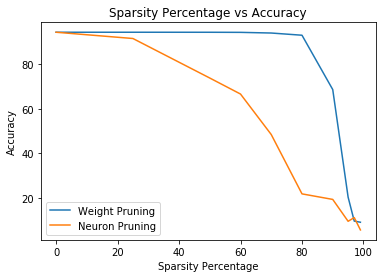

In [12]:
###Plotting the accuracy of both weight and neuron pruning against the percentage of sparsity
import matplotlib.pyplot as plt
plt.plot(sparsity,weight_accuracy,label= 'Weight Pruning');
plt.plot(sparsity,neuron_accuracy,label='Neuron Pruning');
plt.title("Sparsity Percentage vs Accuracy")
plt.xlabel("Sparsity Percentage")
plt.ylabel("Accuracy");
plt.legend()


In [13]:
r = pd.DataFrame()
r['Sparsity Percentage'] = sparsity
r['Weight Pruning Accuracy'] = weight_accuracy
r['Neuron Pruning Accuracy'] = neuron_accuracy

In [14]:
r

,Sparsity Percentage,Weight Pruning Accuracy,Neuron Pruning Accuracy
0,0,94.340003,94.340003
1,25,94.340003,91.530001
2,50,94.330001,73.790002
3,60,94.290000,66.600001
4,70,93.989998,48.420000
5,80,93.000001,21.789999
6,90,68.610001,19.300000
7,95,20.320000,9.480000
8,97,9.570000,11.140000
9,99,9.060000,5.610000
